# Banking project

## Scope of the project

**The goal**:
- To reduce churn rate with the help of user segmentation

**Input data**: 
- User data of a regional bank represented in 3 cities
- Remark: there is some data when client is both marked as active and churned; and there is both some balance and client churned. In such a case, it means that when client churned he was still active and/or had some balance different from 0 


**Analysis structure**:
* Data overview
    * Download data
    * General view (head, info, describe, corr)
* Data preparation
    * Fix columns' names and cases
    * Check for full duplicates
    * Try to workaround with missing values
    * Convert categorical values into quant ones
* EDA
    * Start with corr matrix to see the highest linear dependencies
    * Then dig deeper other aspects
* Users segmentation
    * By age group, gender, city, and number of products
* Hypothesis testing
    * Users estimated salary and number of bank products
    * Credit card posession and churn rate
* Results
* Recommendations
* Presentation

In [80]:
import pandas as pd
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px
import phik

In [81]:
# set options

pd.options.display.float_format = '{:.2f}'.format

## Data overview

In [82]:
# upload data

try:
    df = pd.read_csv('/datasets/bank_dataset.csv')
except:
    df = pd.read_csv('bank_dataset.csv')

### General view

In [83]:
df.head(5)

userid  score       City Gender  Age  Objects   Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2       NaN         1   
1  15690047    608    Рыбинск      Ж   41        1  83807.86         1   
2  15662040    502  Ярославль      Ж   42        8 159660.80         3   
3  15744090    699  Ярославль      Ж   39        1       NaN         2   
4  15780624    850    Рыбинск      Ж   43        2 125510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


There are 12 columns in the dataframe:

1) `userid` - user id  
2) `score` - credit scoring  
3) `City` - city  
4) `Gender` - gender  
5) `Age` - age  
6) `Objects` - the number of property objects  
7) `Balance` — account balance  
8) `Products` - the number of products used by the client  
9) `CreditCard` - whether client has a credit card  
10) `Loyalty` - active client  
11) `estimated_salary` — client's estimated salary  
12) `Churn` - left or not

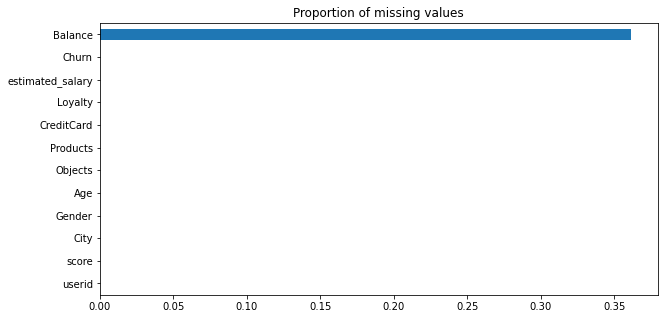

In [85]:
# creates a chart with proportion of missing values

(
    df
     .isna()
     .mean()
     .sort_values()
     .plot(kind='barh', figsize=(10,5), legend=False, title='Proportion of missing values')
);

In a bit more than 35% of entries the `balance` is missing.

That is strange and pity as it supposed to be one of the most important characteristics.

We see further whether anything can be done with it.

In [86]:
df.describe(include='all')

userid    score       City Gender      Age  Objects   Balance  \
count     10000.00 10000.00      10000  10000 10000.00 10000.00   6383.00   
unique         NaN      NaN          3      2      NaN      NaN       NaN   
top            NaN      NaN  Ярославль      М      NaN      NaN       NaN   
freq           NaN      NaN       5014   5457      NaN      NaN       NaN   
mean   15733676.57   650.53        NaN    NaN    38.92     5.01 119827.49   
std       71936.19    96.65        NaN    NaN    10.49     2.89  30095.06   
min    15608437.00   350.00        NaN    NaN    18.00     0.00   3768.69   
25%    15671264.25   584.00        NaN    NaN    32.00     3.00 100181.98   
50%    15733474.00   652.00        NaN    NaN    37.00     5.00 119839.69   
75%    15795969.75   718.00        NaN    NaN    44.00     7.00 139512.29   
max    15858426.00   850.00        NaN    NaN    92.00    10.00 250898.09   

        Products  CreditCard  Loyalty  estimated_salary    Churn  
count   10000.00    10000.00 10000.00          10000.00 10000.00  
unique       NaN         NaN      NaN               NaN      NaN  
top          NaN         NaN      NaN               NaN      NaN  
freq         NaN         NaN      NaN               NaN      NaN  
mean        1.53        0.71     0.52         100090.24     0.20  
std         0.58        0.46     0.50          57510.49     0.40  
min         1.00        0.00     0.00             11.58     0.00  
25%         1.00        0.00     0.00          51002.11     0.00  
50%         1.00        1.00     1.00         100193.91     0.00  
75%         2.00        1.00     1.00         149388.25     0.00  
max         4.00        1.00     1.00         199992.48     1.00

Some interesting findings from fast check:
* Credit scorings mean and median are very close to each other
* The oldest user in the dataframe is 92 years old
* Both users' balances and estimated salaries as well have very tight mean and median, meaning there are no outliers. The max balance and estimated salary are also not very high (even keeping in mind that it is a regional bank) 

In [87]:
df.corr()

userid  score   Age  Objects  Balance  Products  CreditCard  \
userid              1.00   0.01  0.01    -0.01    -0.01      0.02       -0.01   
score               0.01   1.00 -0.00     0.00    -0.00      0.01       -0.01   
Age                 0.01  -0.00  1.00    -0.01    -0.01     -0.03       -0.01   
Objects            -0.01   0.00 -0.01     1.00     0.01      0.01        0.02   
Balance            -0.01  -0.00 -0.01     0.01     1.00     -0.00        0.01   
Products            0.02   0.01 -0.03     0.01    -0.00      1.00        0.00   
CreditCard         -0.01  -0.01 -0.01     0.02     0.01      0.00        1.00   
Loyalty             0.00   0.03  0.09    -0.03    -0.02      0.01       -0.01   
estimated_salary    0.02  -0.00 -0.01     0.01    -0.00      0.01       -0.01   
Churn              -0.01  -0.03  0.29    -0.01     0.02     -0.05       -0.01   

                  Loyalty  estimated_salary  Churn  
userid               0.00              0.02  -0.01  
score                0.03             -0.00  -0.03  
Age                  0.09             -0.01   0.29  
Objects             -0.03              0.01  -0.01  
Balance             -0.02             -0.00   0.02  
Products             0.01              0.01  -0.05  
CreditCard          -0.01             -0.01  -0.01  
Loyalty              1.00             -0.01  -0.16  
estimated_salary    -0.01              1.00   0.01  
Churn               -0.16              0.01   1.00

In terms of linear relationships, most of the characteristics do not have any relationship.

The only interesting points are:
* Age and churn (correlation of around 0,3)
* Loyalty and churn (correlation of around -0,2)

We analyse it further in detail.

For sure, we have two categorical characteristics, i.e. `gender` and `city` which we convert into quant values further and check correlations again.  

## Data preparation

### Columns names and cases

In [88]:
df.columns = df.columns.str.lower()

In [89]:
df.rename(columns={'userid': 'user_id', 'creditcard': 'credit_card', 'loyalty': 'active'}, inplace=True)

### Full duplicates

In [90]:
# check for full duplicates

df.duplicated().sum()

0

There are no full duplicates

In [91]:
# check for duplicates in basic info without unique user id

df[['score', 'city', 'gender', 'age', 'objects', 'balance', 'estimated_salary']].duplicated().sum()

0

There are also no explicit duplicates

### Missing values

As we saw before, around 35% of `balances` are missing.   
We try to understand why and whether there are any dependencies.  
Then we try to workaround if possible.

In [92]:
# flag for zero balances 

df['balance_flag'] = df.apply(lambda x: 0 if pd.isnull(x['balance']) else 1, axis=1)

In [93]:
# columns to check for for-loop 

cols_to_check = ['score', 'city','gender', 'age', 'objects', 'products', 'credit_card', 'active', 'estimated_salary', 'churn']

In [94]:
# histograms charts loop

for col in cols_to_check:
    fig = px.histogram(data_frame=df,
                       x=col, 
                       color='balance_flag', 
                       title=f'Distribution by {col}',
                       histnorm='percent',
                       barmode='overlay',
                       labels=({'x': f'{col}', 'balance_flag': 'balance'}))
    fig.show()

In most of the cases, there is no difference between zero-balances data and non-zero.  
There are only 3 exceptions:
* **City**: there are no missing balances for Rostov at all
* **Number of products**: users, who don't have balance data, have more often 2 bank products; while for users, who have balances, it's more common to have 1 bank product
* **Churn data**: users, whose balances are missing, left the bank in less cases compared to ones for whom there are balances  

Anyhow, we do not see strong dependencies and thus make a conclusion that missing data for `balances` is just a technical issue and we leave them as is as it would not bring us any value and additional info if we apply means or medians.

### Converting categorical values into quant ones 

In [95]:
# flag for the gender

df['gender_flag'] = df['gender'].apply(lambda x: 1 if x=='М' else 0)

In [96]:
# create new columns for next step in order for the original city name not to disappear

df['city_original'] = df['city']

In [97]:
# dummy variable for the city

df = pd.get_dummies(data=df, columns=['city'])

In [98]:
df.head()

user_id  score gender  age  objects   balance  products  credit_card  \
0  15677338    619      Ж   42        2       NaN         1            1   
1  15690047    608      Ж   41        1  83807.86         1            0   
2  15662040    502      Ж   42        8 159660.80         3            1   
3  15744090    699      Ж   39        1       NaN         2            0   
4  15780624    850      Ж   43        2 125510.82         1            1   

   active  estimated_salary  churn  balance_flag  gender_flag city_original  \
0       1         101348.88      1             0            0     Ярославль   
1       1         112542.58      0             1            0       Рыбинск   
2       0         113931.57      1             1            0     Ярославль   
3       0          93826.63      0             0            0     Ярославль   
4       1          79084.10      0             1            0       Рыбинск   

   city_Ростов Великий  city_Рыбинск  city_Ярославль  
0                    0             0               1  
1                    0             1               0  
2                    0             0               1  
3                    0             0               1  
4                    0             1               0

### Intermediate results

* We fixed columns names and cases
* We checked for full and implicit duplicates and didn't find any
* We tried to understand the issue of missing values for 35% of cases of `balance` but didn't find any strong dependencies and decided to leave them as is
* We converted categorical values into quant ones for corr matrix further on

## EDA

We check once again the updated correlation matrix with converted categorical values.

In [99]:
# heatmap chart for corr matrix

fig = px.imshow(df.corr(), text_auto='.2f', aspect="auto")

fig.show()

Converted categorical values brought us some new info about linear dependencies with churn:
* As we saw before, there is lower number of users who churned for those who have balances missing
* We see some linear relationship b/w churn and gender
* There is some correlation as well for users in Rostov and churn

As in general, we see that linear dependencies are pretty low, we also perform Phik correlation check which is a good treatment not only for interval, but also for ordinal and categorical variables, and captures non-linear dependencies well.

In [100]:
# heatmap chart for phik corr matrix

fig = px.imshow(df.phik_matrix(), text_auto='.2f', aspect="auto")

fig.show()

interval columns not set, guessing: ['user_id', 'score', 'age', 'objects', 'balance', 'products', 'credit_card', 'active', 'estimated_salary', 'churn', 'balance_flag', 'gender_flag', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль']


Phik correlation matrix revealed way more relationships among `churn` and others parameters.
The most important ones to analyze are `age`, `city` (especially Rostov), `activity`, and `products`.

This is a good starting point, so we start to dig deeper.  

### General churn

In [101]:
# check overall general churn rate

churn = round(df['churn'].mean() * 100, 2)

print(f'The overall churn rate is {churn}%')

The overall churn rate is 20.37%


### Age

First, we check the overall age distribution to understand how old the users are.

In [102]:
# age distribution

fig = px.histogram(data_frame=df,
                       x='age',
                       title=f'Distribution by age',
                       labels=({'x': 'age', 'balance_flag': 'balance'}))
fig.show()

In [103]:
df['age'].describe()

count   10000.00
mean       38.92
std        10.49
min        18.00
25%        32.00
50%        37.00
75%        44.00
max        92.00
Name: age, dtype: float64

We see that majority of our users are in 30-45 years old - pretty young and economically active.  

We break `age` into categorical age groups in order to better see churn rates.


In [104]:
# to understand age groups, we use qcut 

pd.qcut(df['age'], q=7).unique().sort_values()

[(17.999, 29.0], (29.0, 33.0], (33.0, 36.0], (36.0, 39.0], (39.0, 43.0], (43.0, 49.0], (49.0, 92.0]]
Categories (7, interval[float64, right]): [(17.999, 29.0] < (29.0, 33.0] < (33.0, 36.0] < (36.0, 39.0] < (39.0, 43.0] < (43.0, 49.0] < (49.0, 92.0]]

We decide to do 8 age groups:
1) 18-29 years  
2) 30-33 years  
3) 34-36 years  
4) 37-39 years  
5) 40-43 years  
6) 44-49 years  
7) 50-65 years  
8) 65+ years  

We decided to get pensioneers into separate group as we believe their banking activity is way different from other groups

In [105]:
# create function for age groups

def age_group(row):
    age = row['age']
    
    if age < 30:
        return '18-29 years'
    elif age < 34:
        return '30-33 years'
    elif age < 37:
        return '34-36 years'
    elif age < 40:
        return '37-39 years'
    elif age < 44:
        return '40-43 years'
    elif age < 50:
        return '44-49 years'
    elif age < 66:
        return '50-65 years'
    else:
        return '65+ years'

In [106]:
# apply above function for data set

df['age_group'] = df.apply(age_group, axis=1)

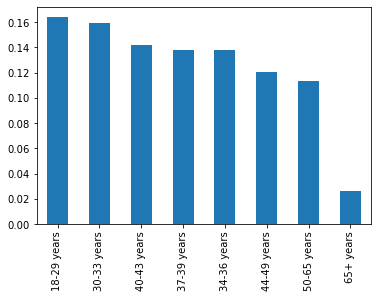

In [107]:
# basic check

df['age_group'].value_counts(normalize=True).plot(kind='bar');

We see that 65+ years group is way smaller than others but we still leave them separetely.  
Others are distributed ok.

In [108]:
# create function for charts

def bar(group_col, data_col, text_fmt, labels_group_col, labels_data_col):
    data = df.groupby(group_col)[data_col].mean().reset_index()

    fig = px.bar(
            data_frame=data,
            x=group_col,
            y=data_col,
            title=f'{labels_data_col} in different {labels_group_col}',
            text_auto=text_fmt,
            labels=({group_col: labels_group_col, data_col: labels_data_col}))

    fig.add_hline(y=df[data_col].mean(), line_width=1, line_dash="dash", line_color="red")

    fig.show()

In [109]:
# churn rate in diff age groups

bar(group_col='age_group',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='age groups',
    labels_data_col='churn rate')

Some findings from the above:
* The majority of our users below 40 years old have churn rate way lower the average of around 20%
* Age group of 40-43 years are almost having an average churn rate
* However, 44-65 years old people leave the bank significantly more often
* Interestingly, pensioneers (age group of 65+ years) have quite low churn rate

So, **we definitely should focus on 44-65 years old users and find ways to involve them better** in order to bring down the overall churn rate. 

In [110]:
# check the activity over diff age groups

bar(group_col='age_group',
    data_col='active',
    text_fmt='.2%',
    labels_group_col='age groups',
    labels_data_col='activity rate')

* We see some downtrend in activity for users till 50 years old
* However, for users of 50+ years there is a big spike in activity, which is quite counter-intuitive
* We check further how activity rate is related to churn rate (the assumption would be that users, who are more active, leave the bank less often on average)
* Thus, we probably need to get 44-49 years age group more engaged

In [111]:
# check the credit card posession over diff age groups

bar(group_col='age_group',
    data_col='credit_card',
    text_fmt='.2%',
    labels_group_col='age groups',
    labels_data_col='credit card posession')

* Overall, almost all the age groups are having the amount of credit cards on the average level of the whole data set, which is around 70%
* However, again age groups of 44-49 and 50-65 years are below the average
* We check further how credit card possesion is related to churn rate (the assumption would be that users, who have credit cards, leave the bank less often on average)
* Thus, we probably need to get those 2 age groups more engaged into credit

### Activity

In [112]:
# check how activity is related to churn

bar(group_col='active',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='activity rate',
    labels_data_col='churn rate')

* As previously assumed, active users have significantly lower churn rate
* So, we should pay attention to users in age groups 34-43 years and max attention to 44-49 years old to bring their activity levels at least to average ones

### Credit cards posession

In [113]:
# check how credit card posession is related to churn

bar(group_col='credit_card',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='credit card posessions',
    labels_data_col='churn rate')

* Rejecting the assumption above, we see that credit card posession does not bring churn rate way lower
* Both situations are resulting in average churn rates
* So, there is no big need into getting clients more involved with credit (at least from the churn view; we do not discuss financial metrics here)

### Gender

In [114]:
# check how gender is related to churn

bar(group_col='gender',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='gender',
    labels_data_col='churn rate')

* We see that women are more inclined to leave/change the bank
* This looks very similar to activity levels, so we quickly check how activity is different for genders

In [115]:
# check how gender is related to activity

bar(group_col='gender',
    data_col='active',
    text_fmt='.2%',
    labels_group_col='gender',
    labels_data_col='activity rate')

* In reality, there is no big diff in activity levels between genders

### City

In [116]:
# check how city is related to churn

bar(group_col='city_original',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='city',
    labels_data_col='churn rate')

* This is big finding, that in Rostov the churn rate is way above the average and peer cities
* We should be focusing on clients there

In [117]:
# we check the distribution over cities

df['city_original'].value_counts(normalize=True)

Ярославль        0.50
Ростов Великий   0.25
Рыбинск          0.25
Name: city_original, dtype: float64

* Fortunately, in Rostov we "only" have 25% of users but still it is a big chunk so fixing the churn there would influence a lot on the overall one 

We dig deeper to check both city and age group influence on the churn

In [118]:
# chart with breakdown by city over age groups with churn rate

data = df.groupby(['age_group', 'city_original'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='age_group',
            y='churn',
            color='city_original',
            barmode='group',
            title='Churn rate over age groups and cities',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'age_group': 'age group', 'city_original': 'city'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* We clearly see that for all age groups churn rate in Rostov way higher than in other cities
* Moreover, for 5 age groups it is above the general average, while in other cities it is a case in only 2 age groups

In [119]:
# chart with breakdown by gender over age groups with churn rate

data = df.groupby(['age_group', 'gender'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='age_group',
            y='churn',
            color='gender',
            barmode='group',
            title='Churn rate over age groups and genders',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'age_group': 'age group', 'gender': 'gender'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* The above chart supports all the statements before
* We should strongly focus on middle age groups and especially women there

In [120]:
# chart with breakdown by gender over cities with churn rate

data = df.groupby(['city_original', 'gender'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='city_original',
            y='churn',
            color='gender',
            barmode='group',
            title='Churn rate over cities and genders',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'city_original': 'city', 'gender': 'gender'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* In the above breakdown, we see that there is space for improvement not only in Rostov but also in other cities for women users

### Products

First, we check the overall distribution to understand how many products the users have.

In [121]:
# products distribution

df['products'].value_counts(normalize=True)

1   0.51
2   0.46
3   0.03
4   0.01
Name: products, dtype: float64

* Around have of the users have just 1 product
* 46% of users have 2 products
* Less than 5% have more than 2 products

In [122]:
# check how number of products is related to churn

bar(group_col='products',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='number of products',
    labels_data_col='churn rate')

* As stated above, users who have more than 2 products are represented in less than 5% of cases, so we don't pay much attention to high churn rates for such users
* The important finding is that for users who have 2 products, the churn rate is way lower than for those users who have just 1 product and for overall churn rate
* Thus, we should focus on pushing the second product to the users who have just 1 

In [123]:
# for users with 3 and 4 products we create new category "2+ products"

df['products_group'] = df['products'].apply(lambda x: '2+ products' if x>2 else x)

In [124]:
# chart with breakdown by number of products over cities with churn rate

data = df.groupby(['city_original', 'products_group'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='city_original',
            y='churn',
            color='products_group',
            barmode='group',
            title='Churn rate over cities and products',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'city_original': 'city', 'products_group': 'number of products'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* Again, the situation is the worst in Rostov
* In all the cities for users who have 1 product the churn rate is above the average
* We neglect '2+ products' as outliers

In [125]:
# chart with breakdown by number of products over age groups with churn rate

data = df.groupby(['age_group', 'products_group'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='age_group',
            y='churn',
            color='products_group',
            barmode='group',
            title='Churn rate over age groups and products',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'age_group': 'age group', 'products_group': 'number of products'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* This is in line with everything we seen before
* Interestingly, users who have 2 products in age group of 50-65 years also have above the average churn rates
* Thus, once again, this age group should be of our main focus

In [126]:
# chart with breakdown by number of products over genders with churn rate

data = df.groupby(['gender', 'products_group'])['churn'].mean().reset_index()

fig = px.bar(data_frame=data,
            x='gender',
            y='churn',
            color='products_group',
            barmode='group',
            title='Churn rate over genders and products',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'gender': 'gender', 'products_group': 'number of products'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* Already not surprisingly, women having any number of products leave more often than men
* Especially, having 1 product

### Other parameters

In [127]:
# check how number of property objects in posession is related to churn

bar(group_col='objects',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='number of property objects in posession',
    labels_data_col='churn rate')

* There is no strong connection b/w number of property objects in posession and churn rate

In [128]:
# to check for the credit score and churn, we first create a function to convert score to categorical

def score(row):
    score = row['score']
    if score < 500:
        return 'under 500'
    elif score < 600:
        return '500-599'
    elif score < 700: 
        return '600-699'
    else:
        return '700+'

In [129]:
# create categorical value for credit score

df['score_cat'] = df.apply(score, axis=1)

In [130]:
# check how credit score is related to churn

bar(group_col='score_cat',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='credit score',
    labels_data_col='churn rate')

* Again, there is no strong connection b/w credit score and churn rate

In [131]:
# to check for the estimated salary and churn, we first create a function to convert salary to categorical

def salary(row):
    salary = row['estimated_salary']
    if salary < 50000:
        return 'under 50k'
    elif salary < 100000:
        return '50-100k'
    elif salary < 150000: 
        return '100-150k'
    else:
        return '150k+'

In [132]:
# create categorical value for the estimated salary

df['salary_cat'] = df.apply(salary, axis=1)

In [133]:
# check how credit score is related to churn

bar(group_col='salary_cat',
    data_col='churn',
    text_fmt='.2%',
    labels_group_col='estimated salary range',
    labels_data_col='churn rate')

* Again, there is no strong connection b/w salary range and churn rate

### Intermediate results

* The overall churn rate is 20.37%

* The majority of our users below 40 years old have churn rate way lower the average
* However, 44-65 years old people leave the bank significantly more often

* As previously assumed, active users have significantly lower churn rate

* Rejecting the primary assumption, credit card posession does not bring churn rate way lower

* Women are more inclined to leave/change the bank

* In Rostov the churn rate is way above the average and peer cities

* For users who have 2 products, the churn rate is way lower than for those users who have just 1 product and for overall churn rate

* There is no strong connections among `churn` and `objects`, `score`, and `estimated_salary`

## User segmentation 

From the EDA done above, we came to the conclusion that the `products`, `age`, `city`, and `gender` are the most important aspects we need to focus on. 

So, we decided to segment users into 24 groups and check churn rates again: we suppose to see the highest levels in middle age + women + Rostov city + 1 product

In [134]:
# regroup the age once again - we do just 3 age groups

def age_group_segments(row):
    age = row['age']
    
    if age < 40:
        return 'young: below 40 years'
    elif age < 66:
        return 'middle age: 41-65 years'
    else:
        return 'pensioneers: 65+ years'

In [135]:
# apply above function for data set

df['age_group_segment'] = df.apply(age_group_segments, axis=1)

In [136]:
# regroup cities as well

df['city_segment'] = df['city_original'].apply(lambda x: 'Rostov' if x=='Ростов Великий' else 'other cities')

In [137]:
# change genders to eng

df['gender'] = df['gender'].apply(lambda x: 'F' if x=='Ж' else 'M')

In [138]:
# create segments

df['segment'] = df[['age_group_segment', 'city_segment', 'gender']].agg(' / '.join, axis=1)

In [139]:
df['segment'].head()

0    middle age: 41-65 years / other cities / F
1    middle age: 41-65 years / other cities / F
2    middle age: 41-65 years / other cities / F
3      young: below 40 years / other cities / F
4    middle age: 41-65 years / other cities / F
Name: segment, dtype: object

<AxesSubplot:>

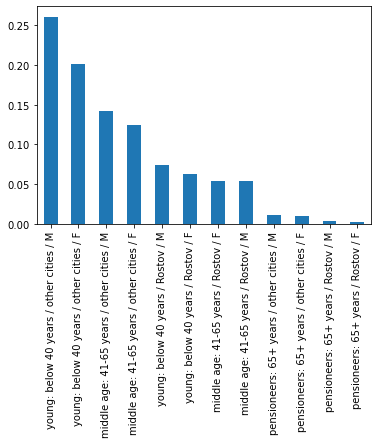

In [140]:
df['segment'].value_counts(normalize=True).plot(kind='bar')

In [141]:
# check how segment is related to churn
# we kill users with 2+ products as they draw too much attention on the chart while being super small

data = df.groupby(['segment', 'products_group'])['churn'].mean().reset_index().sort_values(by='churn', ascending=False)
data = data.query('products_group != "2+ products"')

fig = px.bar(data_frame=data,
            x='segment',
            y='churn',
            color='products_group',
            barmode='group',
            title='Churn rate over segments and products',
            text_auto='.0%',
            labels=({'churn': 'churn rate', 'age_group': 'age group', 'products_group': 'number of products'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* Out of 12 segments with breakdown by number of products (thus, 24 in total), 8 ones need to be worked on
* In all the segments, having 2 products brings the churn rate significantly lower compared to having just 1 product - so, it makes sense to push the second product even in the segments where churn rates are comparably low
* Still, in two segments even for the users having 2 products, the churn rates are above the average: always in Rostov, among female, in middle and pensioneers age group (the second being not so important due to small number of users in that group)


* We need to reorder the data according to the weight of each segment to better understand the priority for further changes

In [142]:
# regroup data including count function to calc weights of each segment

data = (
    df
    .groupby(['segment', 'products_group'])['churn']
    .agg(['mean', 'count'])
    .reset_index()
    .sort_values(by='mean', ascending=False)
)

In [143]:
# calc weights of each segment

data['weight'] = data['count'] / data['count'].sum()

In [144]:
# basic check

data['weight'].sum()

1.0

In [145]:
# kill '2+ products'

data = data.query('products_group != "2+ products"')

In [146]:
# calc weighted churn to understand the priority for the segment focus

data['weighted_churn'] = data['mean'] * data['weight']

data = data.sort_values(by='weighted_churn', ascending=False)

In [147]:
# redraw the chart to better see the priority of focus

fig = px.bar(data_frame=data,
            x='segment',
            y='mean',
            color='products_group',
            barmode='group',
            title='Churn rate over segments and products (segments sorted in the order of the priority of changes)',
            text_auto='.0%',
            labels=({'mean': 'churn rate', 'age_group': 'age group', 'products_group': 'number of products'}))

fig.add_hline(y=df['churn'].mean(), line_width=1, line_dash="dash", line_color="red")

fig.show()

* Main conclusion: **middle age group in all the cities with only 1 product should be in primary focus**
* Further on in the end, we come with more precise recommendations

### Intermediate results

* We have formed 24 segments of users based on the age range, gender, city, and number of bank products

* When ordering the segments by weighted churn rate (as on the last chart), we came to conclusion that there are 3 priority stages to bring the overall churn rate lower:  
    1) Primary focus on the middle age group in all the cities of both genders with only 1 product  
    2) Target female users in Rostov in young and pensioneers age groups with both 1 and 2 products  
    3) Push the second product to users who have just 1 product in all other segments, as having 2 products brings the churn rate significantly lower

## Hypothesis testing


### Users estimated salary and number of bank products

We form the hypothesis:

H0: Estimated salary of users having 2 products is the same of users having only 1 product  
H1: Estimated salary of users having 2 products is **not** the same of users having only 1 product

Alpha: 0,05

In [148]:
# slice df

df_1_product = df.query('products == 1')
df_2_products = df.query('products == 2')

In [149]:
len(df_1_product)

5084

In [150]:
len(df_2_products)

4590

Groups are more or less of equal size.

We check for the distributions of estimated salaries.

In [151]:
# charts with distributions

df_products = df.query('products == 1 or products == 2')

fig = px.histogram(data_frame=df_products,
                  x='estimated_salary',
                  color='products',
                  title='Distribution of estimated salaries',
                  labels=({'estimated_salary': 'estimated salary', 'products': 'number of products'}))

fig.show()

* Distributions for users with both 1 and 2 bank products are almost discrete uniform ones
* As we have quant values, non-normal distributed, indipendent, and we compare 2 groups - we have to use Mann–Whitney U test for this hypothesis 

In [152]:
# Mann–Whitney U test

results = st.mannwhitneyu(df_1_product['estimated_salary'], df_2_products['estimated_salary'])
print(f'p-value: {results.pvalue:.5f}')

p-value: 0.40796


P-value for this t-test is around 41%, so independently on any confidence level choosen being 1% and 5% - the **H0 can not be rejected**.  

We have no reason to believe that the estimated salaries of users having 2 and 1 bank products are significantly different.

### Credit card posession and churn rate

Above, we saw that there is no strong relation b/w credit card posession and churn rate.

We want to check it statistically as well.

We form the hypothesis:

H0: Users having credit cards have the same churn rate as users not having credit cards  
H1: Users having credit cards have **not** the same churn rate as users not having credit cards 

Alpha: 0,05

In [153]:
# slice df

df_credit_yes = df.query('credit_card == 1')
df_credit_no = df.query('credit_card == 0')

In [154]:
len(df_credit_yes)

7055

In [155]:
len(df_credit_no)

2945

* Groups are not of even close sizes.
* As we have binary distributed, indipendent, and we compare 2 groups - we have to use Z-test for proportions for this hypothesis

In [156]:
# calc needed inputs for z test

successes = np.array([df_credit_yes['churn'].sum(), df_credit_no['churn'].sum()])
trials = np.array([len(df_credit_yes), len(df_credit_no)])

In [157]:
# Proportions Z test

results = proportions_ztest(count=successes, nobs=trials)
print(f'p-value: {results[1]:.5f}')

p-value: 0.47537


P-value for this t-test is around 48%, so independently on any confidence level choosen being 1% and 5% - the H0 can not be rejected.

We have no reason to believe that the churn rates of users having a credit card and not are significantly different.

### Intermediate results

* We tested 2 hypothesis in both of which H0 can not be rejected:  
    1) We have no reason to believe that the average estimated salaries of users having 2 and 1 bank products are significantly different  
    2) We have no reason to believe that the churn rates of users having a credit card and not are significantly different

## Results

* We had users data from regional bank having offices in 3 cities
* Our main goal was to understand how to lower the churn rate with the help of users segmentation


* We fixed columns names and cases
* We checked for full and implicit duplicates and didn't find any
* We tried to understand the issue of missing values for 35% of cases of `balance` but didn't find any strong dependencies and decided to leave them as is
* We converted categorical values into quant ones for corr matrix further on


* The overall churn rate is 20.37%
* The majority of our users below 40 years old have churn rate way lower the average
* However, 44-65 years old people leave the bank significantly more often
* As previously assumed, active users have significantly lower churn rate
* Rejecting the primary assumption, credit card posession does not bring churn rate way lower
* Women are more inclined to leave/change the bank
* In Rostov the churn rate is way above the average and peer cities
* For users who have 2 products, the churn rate is way lower than for those users who have just 1 product and for overall churn rate
* There is no strong connections among `churn` and `objects`, `score`, and `estimated_salary`


* We have formed 24 segments of users based on the age range, gender, city, and number of bank products
* When ordering the segments by weighted churn rate (as on the last chart), we came to conclusion that there are 3 priority stages to bring the overall churn rate lower:  
    1) Primary focus on the middle age group in all the cities of both genders with only 1 product  
    2) Target female users in Rostov in young and pensioneers age groups with both 1 and 2 products  
    3) Push the second product to users who have just 1 product in all other segments, as having 2 products brings the churn rate significantly lower
    

* We tested 2 hypothesis in both of which H0 can not be rejected:  
    1) We have no reason to believe that the average estimated salaries of users having 2 and 1 bank products are significantly different  
    2) We have no reason to believe that the churn rates of users having a credit card and not are significantly different

## Recommendations

As stated above, we see that the work on lowering the churn rate should be done in 3 stages.

Here are some ideas:
1. **Push the second product** to all the segments, especially in the middle age of 41-65 years old
2. As in some segments with even 2 products, churn rates for women in Rostov in the middle and pensioneers age groups are higher than on average, **get partnerships with local businesses** focused on travel and cultural events, home and gardering, and child and grandchild care **to provide more cashback and/or special discounts when bank products are used**
3. It might be that the bank is mostly done by and for youngsters, so some concepts can be not-easily understandable to people in middle and pensioneer age ranges, so it might be appropriate to **generate more stories in the bank app and/or write more articles in the bank blog and social media** explaining how banking products work and what benefits they bring
4. **Create new debit product for juniors (under 18 years old)** which can have significant effect on women having children, as junior card would be connected to the parent one and it would be harder to churn 
5. **Develop new joint family accounts** which can hook both genders to stay longer in the bank

## Presentation

Link to presentation: <https://drive.google.com/file/d/1-IFmMvtSvSWhBL4u2PjD45kVtoHFrp4j/view?usp=sharing>